<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-1/blob/main/13%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_0527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 ch7. 3~4

pg. 427-440

# [Chapter 7] 군집화

## 7-3. 평균 이동

### 평균 이동(Mean Shift)의 개요

평균 이동 : 데이터가 모여 있는 밀도가 가장 높은 곳으로 중심을 이동시키면서 군집화를 수행
- 군집 중심점 : 확률 밀도 함수가 피크인 점을 선정 (KDE(Kernel Density Estimation) 이용)
- KDE 함수에 주변 데이터와의 거리 값을 입력한 뒤, 반환 값을 현재 위치에서 업데이트하면서 이동

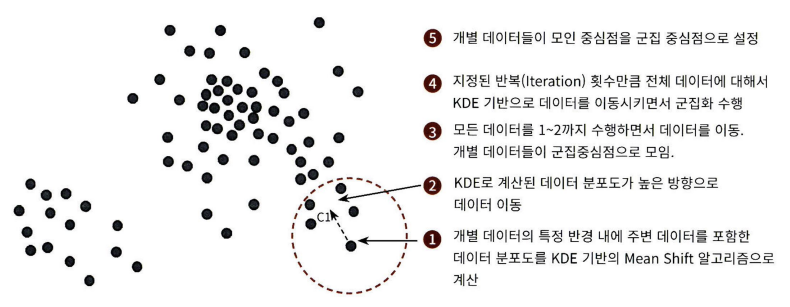

- KDE : 개별 관측 데이터에 커널 함수 적용한 값을 모두 더하고 데이터 건수로 나눠 확률 밀도 함수 추정
  - 커널 함수에 대표적으로 가우시안 분포 함수 사용

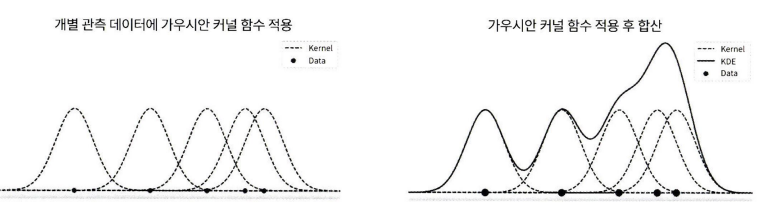

- 커널 함수식
  - K : 커널 함수
  - x : 확률 변숫값
  - xi : 관측값
  - h : 대역폭(bandwidth)

  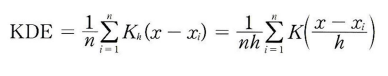

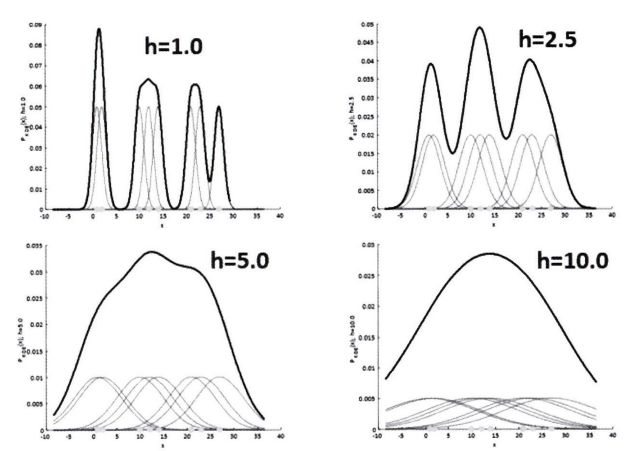

- 대역폭 h : KDE 형태를 부드러운 형태로 평활화(smoothing)하는데 적용
  - 확률 밀도 추정 성능 크게 좌우
  - 작은 h 값 : 좁고 뾰족한 KDE, 변동성이 큰 방식으로 확률 밀도 함수를 추정하므로 **과적합**하기 쉬움 / 군집 중심점이 많음
  - 큰 h 값 : 과도하게 평활화된 KDE로 인해 지나치게 단순화된 방식으로 확률 밀도 함수를 추정하여 **과소적합**하기 쉬움 / 군집 중심점이 적음

  -> 적절한 KDE의 대역폭 h를 계산하는 것은 KDE 기반의 평균 이동 군집화에서 매우 중요


In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


- bandwidth 0.8로 설정
  - 지나치게 세분화돼 군집화됨
  - bandwidth 값을 작게 할수록 군집 개수가 많아짐

In [ ]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- bandwidth 1.0로 설정
  - 3개의 군집으로 잘 군집화됨

In [ ]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


- estimate_bandwidth : 파라미터로 피처 데이터 세트를 입력하면 최적화된 bandwidth 값 반환

In [ ]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


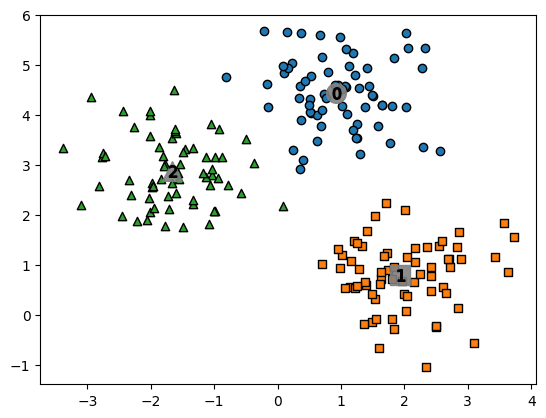

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  # 군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  # 군집별 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9,
              marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [ ]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


- Target 값과 군집 label 값이 1:1로 잘 매칭됨

[평균 이동 장점]
- 유연한 군집화 가능
  - 데이터 세트를 특정 형태로 가정하거나, 특정 분포도 기반의 모델로 가정하지 않기 때문
- 이상치의 영향력이 크지 않음
- 군집 개수를 미리 정할 필요 없음

[단점]
- 수행 시간이 오래 걸림
- bandwidth 크기에 따른 군집화 영향도가 매우 큼

-> 컴퓨터 비전 영역에서 많이 사용(vs 분석 업무 기반의 데이터 세트)

## 7-4. GMM(Gaussian Mixture Model)

### GMM(Gaussian Mixture Model) 소개

여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성되었다고 가정하여 군집화 수행

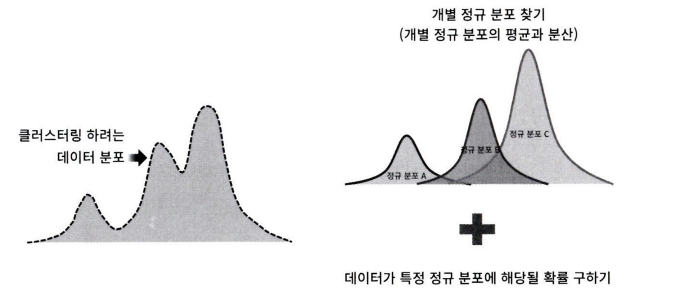

- 모수 추정
  - 개별 정규 분포의 평균과 분산
  - 각 데이터가 어떤 정규 분포에 해당되는지의 확률
  - EM(Expectation and Maximization) 방법 적용

### GMM을 이용한 붓꽃 데이터 세트 군집화

- GaussianMixture 클래스 파라미터
  - n_components : gaussian mixture의 모델 총 개수

In [ ]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼 명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


- Target 0은 cluster 0으로, Target 2는 cluster 1으로 모두 잘 매핑됨
- Target 1은 cluster 2 45개, cluster 1 5개 매핑
- K-평균 군집화 결과보다 더 효과적인 분류 결과 도출

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


- 붓꽃 데이터 세트가 GMM 군집화에 더 효과적
- 어떤 알고리즘이 더 뛰어나다는 의미 x
- K-평균은 개별 군집 내의 데이터가 원형으로 흩어져 있는 경우에 매우 효과적으로 군집화 수행

### GMM과 K-평균의 비교


- KMeans는 데이터 세트가 원형의 범위를 가질수록 군집화 효율이 높아짐
- but 데이터가 길쭉한 타원형일 경우 군집화를 잘 수행하지 못함

In [ ]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

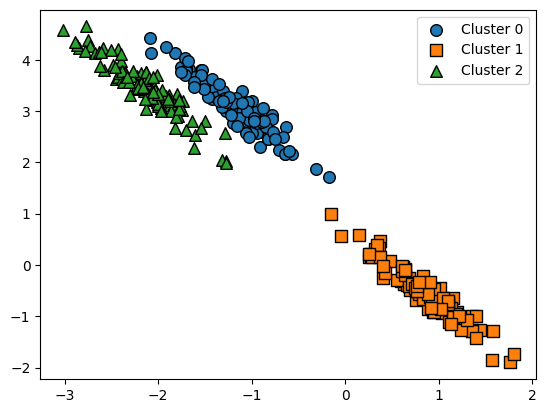

In [ ]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253299]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

- 위와 같은 데이터 세트에서는 KMeans의 군집화 정확성이 떨어짐

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


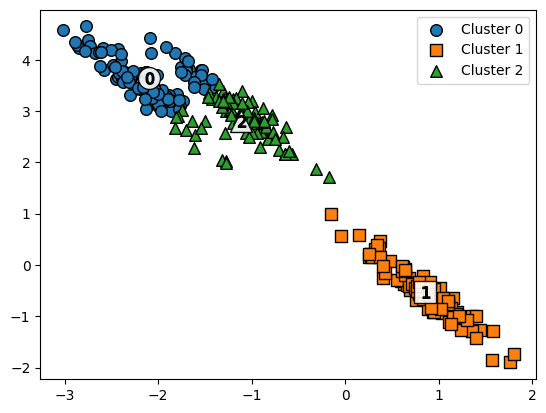

In [ ]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

- KMeans로 군집화 수행
  - 주로 원형으로 개별 군집화가 됨
  - 길쭉한 방향으로 데이터가 밀접해 있는 경우 최적의 군집화가 어려움 (평균 거리 기반으로 군집화 수행하기 때문)

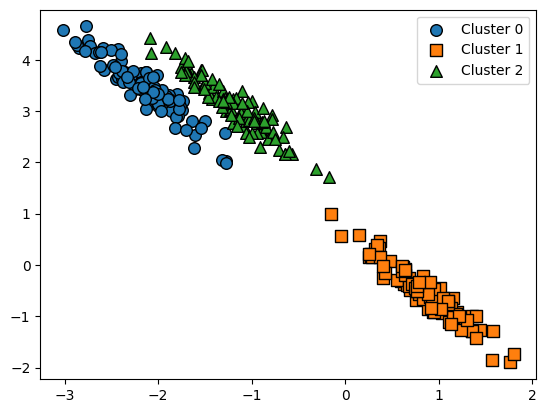

In [ ]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

- GMM
  - 데이터가 분포된 방향에 따라 정확하게 군집화됨
  - GMM은 군집의 중심 좌표를 구할 수 없음

In [ ]:
print('### KMenas Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMenas Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64
### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


- KMeans
  - 군집 1번만 정확히 매핑, 나머지 군집은 target 값과 어긋나는 경우 발생
- GMM
  - 군집이 target 값과 잘 매핑됨



[정리]
- GMM은 보다 유연하게 다양한 데이터 세트에 적용할 수 있다는 장점이 있지만 수행시간이 오래 걸림